# Fine-Tune BERT LLM for Sentiment Analysis with Kubeflow PyTorchJob

This Notebook will fine-tune Bidirectional Encoder Representations from Transformers (BERT) model with Yelp dataset to analyze text sentiment using distributed training with [Kubeflow PyTorchJob](https://www.kubeflow.org/docs/components/training/overview/).

Pretrained BERT model: https://huggingface.co/google-bert/bert-base-cased

Yelp review full dataset: https://huggingface.co/datasets/yelp_review_full

This Notebook requires:

- At least **3 GPU** on your Kubernetes cluster to fine-tune BERT model on 3 workers.
- AWS S3 bucket to export fine-tuned model.

This example is based on [the HuggingFace fine-tuning tutorial](https://huggingface.co/docs/transformers/en/training).

## Install required packages

We need to install HuggingFace packages to run this Notebook.

In [ ]:
!pip install transformers datasets boto3

!pip install git+https://github.com/kubeflow/training-operator.git#subdirectory=sdk/python

## Get samples from Yelp reviews dataset

The Yelp reviews full star dataset is constructed by randomly taking 130,000 training samples and 10,000 testing samples for each review star from 1 to 5.

In total there are 650,000 training samples and 50,000 testing samples.

We are going to use this dataset to fine-tune BERT model.

In [2]:
from pprint import pprint

from datasets import load_dataset

# Test only 100 samples in the Notebook.
dataset = load_dataset("yelp_review_full", split="train[:100]")

# Print some test data.
pprint(dataset[5])
pprint(dataset[30])

{'label': 4,
 'text': "Top notch doctor in a top notch practice. Can't say I am surprised "
         'when I was referred to him by another doctor who I think is '
         'wonderful and because he went to one of the best medical schools in '
         'the country. \\nIt is really easy to get an appointment. There is '
         'minimal wait to be seen and his bedside manner is great.'}
{'label': 1,
 'text': 'Average run of the mill store.  Associates are young teens and they '
         "really don't know where anything is.  Luckily I am able to get "
         'around to find everything.  Found my puppy treats and moved on.'}


## Create script to fine-tune BERT model

We need to wrap our fine-tuning script in a function to create Kubeflow PyTorchJob.

In [3]:
def train_func(parameters):
    import os

    import boto3
    import evaluate
    import numpy as np
    from datasets import load_dataset
    from datasets.distributed import split_dataset_by_node
    from transformers import (
        AutoModelForSequenceClassification,
        AutoTokenizer,
        Trainer,
        TrainingArguments,
    )

    # [1] Download BERT model, tokenizer, and Yelp dataset.
    print("-" * 40)
    print("Download BERT Model")
    model = AutoModelForSequenceClassification.from_pretrained(
        "bert-base-cased",
        num_labels=5,
    )
    tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

    print("-" * 40)
    print("Download Yelp Review Dataset")

    # Use only 4000 data samples to reduce tokenization and training time.
    # Training samples - 3600, test samples - 400
    # Remove split to take all samples: dataset = load_dataset("yelp_review_full")
    dataset = load_dataset("yelp_review_full", split="train[:4000]")
    dataset = dataset.train_test_split(test_size=0.1, stratify_by_column="label")

    # [2] Preprocess dataset.
    def tokenize_function(examples):
        return tokenizer(examples["text"], padding="max_length", truncation=True)

    # Map Yelp review dataset to BERT tokenizer.
    print("-" * 40)
    print("Map Yelp review dataset to BERT Tokenizer")
    tokenized_ds = dataset.map(tokenize_function, batched=True)

    # Distribute train and test datasets between PyTorch workers.
    # Every worker will process chunk of training data.
    # RANK and WORLD_SIZE will be set by Kubeflow Training Operator.
    RANK = int(os.environ["RANK"])
    WORLD_SIZE = int(os.environ["WORLD_SIZE"])
    distributed_ds_train = split_dataset_by_node(
        tokenized_ds["train"],
        rank=RANK,
        world_size=WORLD_SIZE,
    )
    distributed_ds_test = split_dataset_by_node(
        tokenized_ds["test"],
        rank=RANK,
        world_size=WORLD_SIZE,
    )

    # Evaluate accuracy.
    metric = evaluate.load("accuracy")

    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        predictions = np.argmax(logits, axis=-1)
        return metric.compute(predictions=predictions, references=labels)

    # [3] Define Training args.
    training_args = TrainingArguments(
        output_dir="test_trainer",
        evaluation_strategy="epoch",
        disable_tqdm=True,
        log_level="info",
    )

    # [4] Define Trainer.
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=distributed_ds_train,
        eval_dataset=distributed_ds_test,
        compute_metrics=compute_metrics,
    )

    # [5] Fine-tune model.
    print("-" * 40)
    print(f"Start Distributed Training. RANK: {RANK} WORLD_SIZE: {WORLD_SIZE}")

    trainer.train()

    print("-" * 40)
    print("Training is complete")

    # [6] Export trained model to S3 from the worker with RANK = 0.
    if RANK == 0:
        trainer.save_model("./bert")
        s3 = boto3.resource("s3")
        bucket = s3.Bucket(parameters["BUCKET"])
        bucket.upload_file("bert/config.json", "bert/config.json")
        bucket.upload_file("bert/model.safetensors", "bert/model.safetensors")

    print("-" * 40)
    print("Model is exported to S3")

## Create Kubeflow PyTorchJob to fine-tune BERT on GPUs

Use `TrainingClient()` to create PyTorchJob which will fine-tune BERT on **3 workers** using **1 GPU** for each worker.

Your Kubernetes cluster should have sufficient **GPU** resources available.

In [4]:
import uuid
from kubeflow.training import TrainingClient

job_name = "fine-tune-bert"

# Replace `kubeflow-examples` with your AWS S3 bucket.
bucket = "kubeflow-examples"

In [5]:
# Create PyTorchJob
TrainingClient().create_job(
    name=job_name,
    train_func=train_func,
    parameters={"BUCKET": bucket},
    num_workers=3,  # Number of PyTorch workers to use.
    resources_per_worker={
        "cpu": "4",
        "memory": "10G",
        "gpu": "1",
    },
    packages_to_install=[
        "boto3",
        "transformers",
        "datasets",
        "evaluate",
        "accelerate",
        "scikit-learn",
    ],  # PIP packages will be installed during PyTorchJob runtime.
)

### Check the PyTorchJob conditions

Use `TrainingClient()` APIs to get information about created PyTorchJob.

In [6]:
print("PyTorchJob Conditions")
print(TrainingClient().get_job_conditions(job_name))
print("-" * 40)

# Wait until PyTorchJob has Running condition.
job = TrainingClient().wait_for_job_conditions(
    job_name,
    expected_conditions={"Running"},
)
print("PyTorchJob is running")

PyTorchJob Conditions
[{'last_transition_time': datetime.datetime(2024, 3, 15, 16, 31, 30, tzinfo=tzutc()),
 'last_update_time': datetime.datetime(2024, 3, 15, 16, 31, 30, tzinfo=tzutc()),
 'message': 'PyTorchJob fine-tune-bert is created.',
 'reason': 'PyTorchJobCreated',
 'status': 'True',
 'type': 'Created'}, {'last_transition_time': datetime.datetime(2024, 3, 15, 16, 31, 31, tzinfo=tzutc()),
 'last_update_time': datetime.datetime(2024, 3, 15, 16, 31, 31, tzinfo=tzutc()),
 'message': 'PyTorchJob fine-tune-bert is running.',
 'reason': 'PyTorchJobRunning',
 'status': 'True',
 'type': 'Running'}]
----------------------------------------
PyTorchJob is running


### Get the PyTorchJob pod names

Since we set 3 workers, PyTorchJob will create 1 master pod and 2 worker pods to execute distributed training.

In [7]:
TrainingClient().get_job_pod_names(job_name)


['fine-tune-bert-master-0',
 'fine-tune-bert-worker-0',
 'fine-tune-bert-worker-1']

### Get the PyTorchJob training logs

Every worker processes 1200 training samples on each epoch since we distribute 3600 training samples across 3 workers.

In [8]:
logs, _ = TrainingClient().get_job_logs(job_name, follow=True)


[Pod fine-tune-bert-master-0]: WARNING: Running pip as the 'root' user can result in broken permissions and conflicting behaviour with the system package manager. It is recommended to use a virtual environment instead: https://pip.pypa.io/warnings/venv
[Pod fine-tune-bert-master-0]: WARNING: Running pip as the 'root' user can result in broken permissions and conflicting behaviour with the system package manager. It is recommended to use a virtual environment instead: https://pip.pypa.io/warnings/venv
[Pod fine-tune-bert-master-0]: ----------------------------------------
[Pod fine-tune-bert-master-0]: Download BERT Model
[Pod fine-tune-bert-master-0]: Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
[Pod fine-tune-bert-master-0]: You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[Pod fine-tune-ber

### Download the fine-tuned model

We can download our fine-tuned BERT model from S3 to evaluate it.

In [9]:
import boto3
import os

s3 = boto3.resource("s3")
bucket = s3.Bucket(bucket)

# config.json is the model metadata.
# model.safetensors is the model weights & biases.
if not os.path.exists("bert"):
    os.makedirs("bert")
bucket.download_file("bert/config.json", "bert/config.json")
bucket.download_file("bert/model.safetensors", "bert/model.safetensors")

### Test the fine-tuned BERT model

We are going to use HuggingFace pipeline to test our model.

We will ask for sentiment analysis task for our fine-tuned LLM.

In [10]:
from transformers import AutoTokenizer, pipeline

# During fine-tuning BERT tokenizer is not changed.
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

# Use pipeline with sentiment-analysis task to evaluate our model.
nlp = pipeline("sentiment-analysis", model="./bert", tokenizer=tokenizer)

good_review = "This is one of the best restaurants I've ever been to."
bad_review = "I am upset by using this service. It is very expensive and quality is bad."

print(good_review)
res = nlp(good_review)

print("Star: ", res[0]["label"][6])
print("Score: ", res[0]["score"])
print("---------------------------\n\n")


print(bad_review)
res = nlp(bad_review)

print("Star: ", res[0]["label"][6])
print("Score: ", res[0]["score"])
print("---------------------------")

This is one of the best restaurants I've ever been to.
Star:  4
Score:  0.806443452835083
---------------------------


I am upset by using this service. It is very expensive and quality is bad.
Star:  1
Score:  0.6581875085830688
---------------------------


## Use Train API to Fine-Tune BERT LLM

Kubeflow Training Operator SDK implements a `train` API to effectively fine-tune LLMs on multiple PyTorchJob workers with required configuration. It uses storage initializer to download pre-trained model and dataset, and distribute it across PyTorchJob workers using shared PVCs. After initialization step, pre-created HuggingFace LLM trainer will be executed on each PyTorchJob worker to fine-tune BERT model.

This feature is in **Development Phase**, please provide your feedback by creating [the GitHub issues](https://github.com/kubeflow/training-operator/issues/new) or by using [the Kubeflow Slack channel #kubeflow-training-operator](https://kubeflow.slack.com/archives/C985VJN9F).

To learn more about it check [this proposal](https://github.com/kubeflow/training-operator/blob/master/docs/proposals/train_api_proposal.md).

**TODO (andreyvelich)**: Add docs link when they are ready.

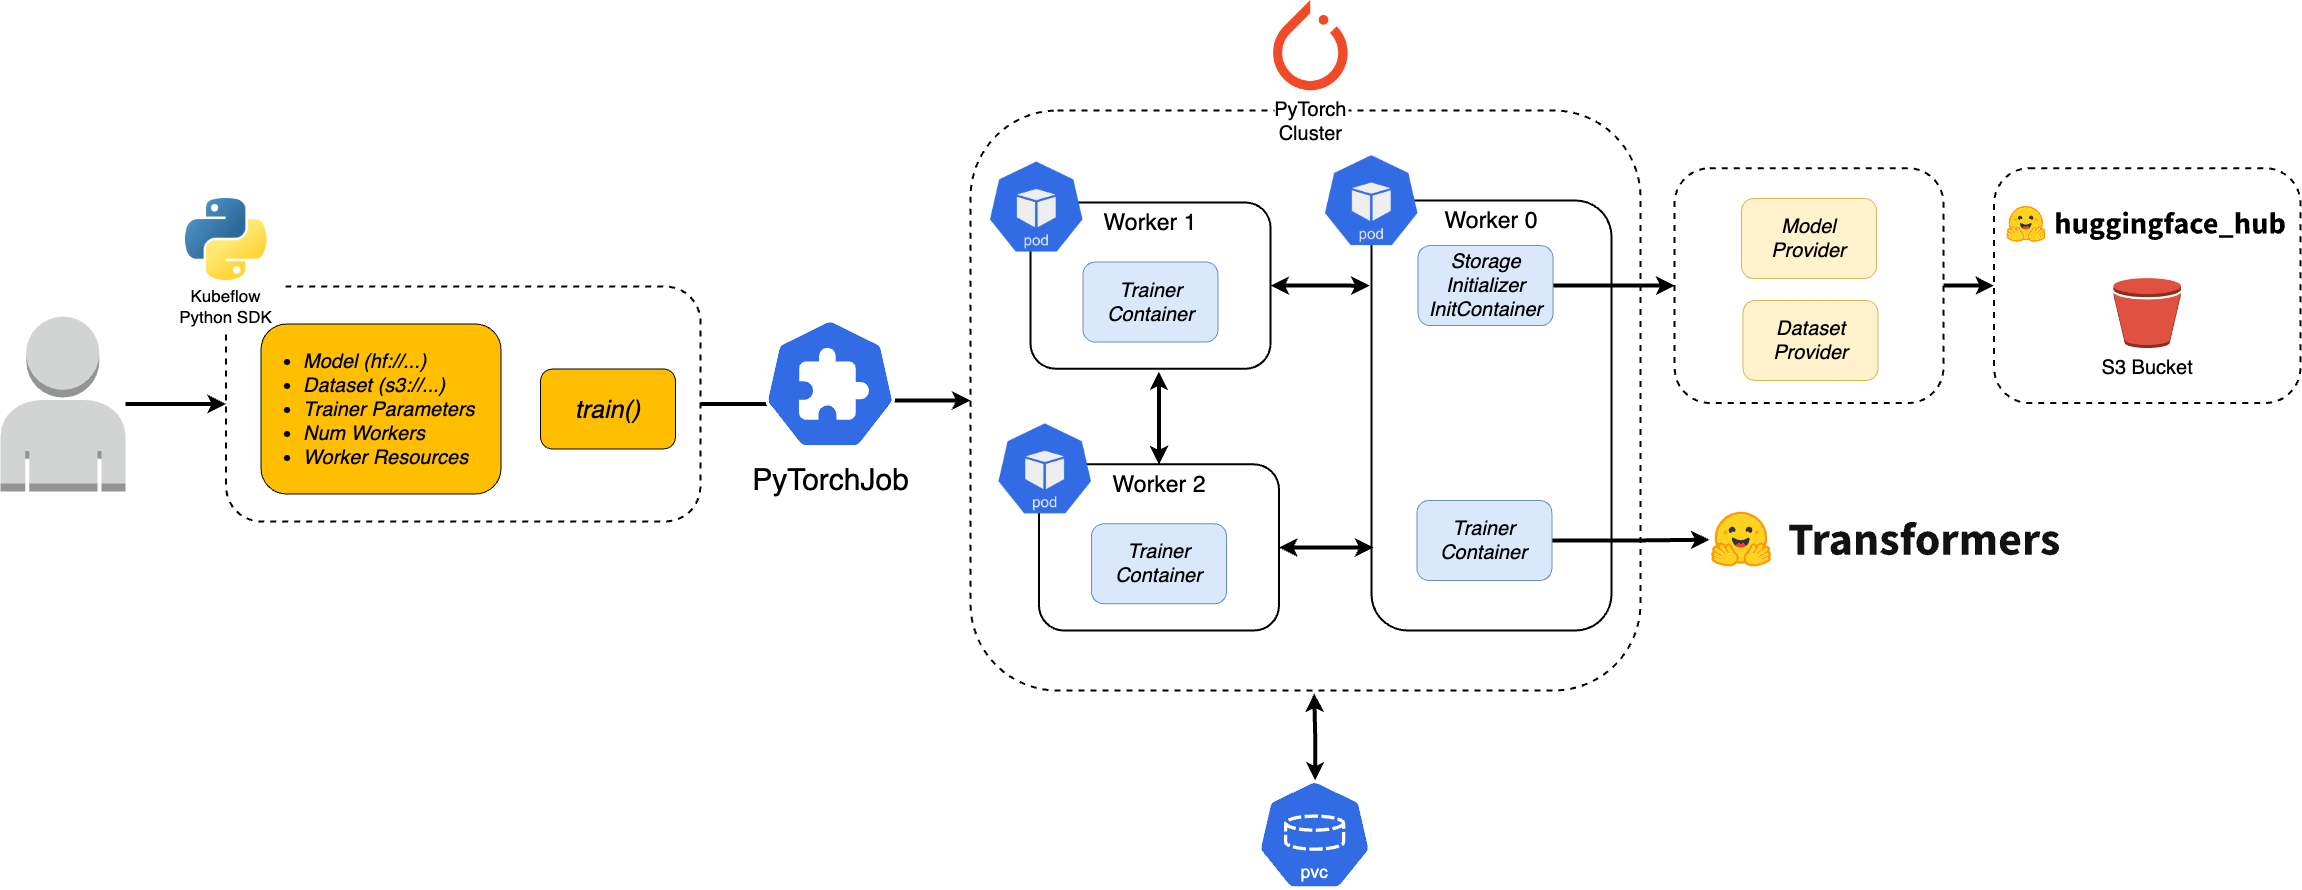


### Install Training Operator SDK to use `train` API

You have to install `kubeflow-training` SDK with the HuggingFace dependencies to use `train` API.


In [ ]:
!pip install "kubeflow-training[huggingface] @ git+https://github.com/kubeflow/training-operator.git#subdirectory=sdk/python"

### Create PyTorchJob using train API

If your Kubernetes environment [supports `ReadOnlyMany` and `ReadWriteOnce` access modes](https://kubernetes.io/docs/concepts/storage/persistent-volumes/#access-modes) for PersistentVolumeClaims (PVCs), you can use more than 1 PyTorchJob worker in `train` API.

In [12]:
from kubeflow.training import TrainingClient
from kubeflow.storage_initializer.hugging_face import (
    HuggingFaceModelParams,
    HuggingFaceTrainerParams,
    HuggingFaceDatasetParams,
)

import transformers
from peft import LoraConfig

job_name_train_api = "fine-tune-bert-train-api"

# Set TOKENIZERS_PARALLELISM = false to avoid warnings from Transformers.
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [20]:
# In this example we will use 1 worker and 1 GPU to fine-tune BERT with `train` API.
TrainingClient().train(
    name=job_name_train_api,
    num_workers=1, # nnodes parameter for torchrun command.
    num_procs_per_worker=1, # nproc-per-node parameter for torchrun command.
    # BERT model URI and type of Transformer to train it.
    model_provider_parameters=HuggingFaceModelParams(
        model_uri="hf://google-bert/bert-base-cased",
        transformer_type=transformers.AutoModelForSequenceClassification,
    ),
    storage_config={
        "access_modes": ["ReadWriteOnce"] # Since we use 1 Worker, PVC access mode is ReadWriteOnce.
    },
    # Use 3000 samples from Yelp dataset.
    dataset_provider_parameters=HuggingFaceDatasetParams(
        repo_id="yelp_review_full",
        split="train[:3000]",
    ),
    # Specify HuggingFace Trainer parameters. In this example, we will skip evaluation and model checkpoints.
    trainer_parameters=HuggingFaceTrainerParams(
        training_parameters=transformers.TrainingArguments(
            output_dir="test_trainer",
            save_strategy="no",
            evaluation_strategy="no",
            do_eval=False,
            disable_tqdm=True,
            log_level="info",
        ),
        # Set LoRA config to reduce number of trainable model parameters.  
        lora_config=LoraConfig(
            r=8,
            lora_alpha=8,
            lora_dropout=0.1,
            bias="none",
        ),
    ),
    resources_per_worker={
        "gpu": 1,
        "cpu": 5,
        "memory": "10G",
    },
)

### Get the PyTorchJob containers

When using `train` API, every PyTorchJob worker (Kubernetes Pod) should have `storage-initialize` initContainer and volume.


In [21]:
pytorchjob = TrainingClient().get_job(job_name_train_api)

print("PyTorchJob Init Containers")
for c in pytorchjob.spec.pytorch_replica_specs["Master"].template.spec.init_containers:
    print(c.name)

print("-" * 40)

print("PyTorchJob Volumes")
for v in pytorchjob.spec.pytorch_replica_specs["Master"].template.spec.volumes:
    print(v.name)

PyTorchJob Init Containers
storage-initializer
----------------------------------------
PyTorchJob Volumes
storage-initializer


### Get the PyTorchJob training logs

Use the same API to get created PyTorchJob logs.

Since we used LoRA config, number of trainable parameters is smaller: **294 912**

In [22]:
logs, _ = TrainingClient().get_job_logs(job_name_train_api, follow=True)


[Pod fine-tune-bert-train-api-master-0]: 2024-03-15T16:45:47Z INFO     Starting HuggingFace LLM Trainer
[Pod fine-tune-bert-train-api-master-0]: /usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1741: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
[Pod fine-tune-bert-train-api-master-0]:   warnings.warn(
[Pod fine-tune-bert-train-api-master-0]: 2024-03-15T16:45:47Z INFO     Setup model and tokenizer
[Pod fine-tune-bert-train-api-master-0]: Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
[Pod fine-tune-bert-train-api-master-0]: You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[Pod fine-tune-bert-train-api-master-0]: 2024-03-15T16:45:48Z INFO     Preprocess dataset
[Pod fine-tune-bert

## Delete the PyTorchJobs

You can delete the created PyTorchJobs.

In [23]:
TrainingClient().delete_job(name=job_name)

In [24]:
TrainingClient().delete_job(name=job_name_train_api)